In [1]:
CREATE_TEMP_TABLE_CUSTOMER_DATA = """
    create temp table loan as (
        SELECT
        DISTINCT
        LOWER(customer_id::text) AS customer_id,
        credit_score,
        LOWER(country) AS country,
        LOWER(gender) AS gender,
        age,
        tenure,
        balance,
        products_number,
        credit_card,
        active_member,
        estimated_salary,
        churn
    FROM customer_data
    );
"""


GET_DATA = """
    select 
        customer_id, credit_score, country, gender, age, tenure, balance, products_number, credit_card, active_member, estimated_salary, churn
    from customer_data
"""

In [2]:
%pip install psycopg2
import psycopg2

Note: you may need to restart the kernel to use updated packages.


In [3]:
import datetime
import sys
import os
import json
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.sql import text
from importlib import reload

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'dags', 'src'))

#make sure you have SQL Credentials.json stored in dags folder
import helpers
import config
import queries

[INFO] Connection to `localhost:postgres` initiated!


In [4]:
#### helpers.py methods ####
def save_dataset(df:pd.DataFrame, path:str):
    """
    Save data set.
    :param df: DataFrame
    :param path: str
    :return: None
    """
    df.to_csv(path, index=False)
    print(f"[INFO] Dataset saved to {path}")

In [5]:
credentials = json.load(open(config.PATH_TO_CREDENTIALS, 'r'))
engine = create_engine(f"postgresql://{credentials['user']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['database']}")

In [6]:
def extract_data(start_date: datetime.date, end_date: datetime.date = datetime.date.today()) -> pd.DataFrame:
    """
    Extracts data from the database and returns it as a pandas dataframe.
    Queries are to be defined in the `queries.py` file.
    :param start_date: start date of the data to be extracted
    :param end_date: end date of the data to be extracted
    :return: pandas dataframe
    """
    assert start_date <= end_date, "start_date must be less than end_date"
    print("[INFO] Extracting data from the database since {0} to {1} ...".format(start_date, end_date))

    # Connect to the database using a context manager to handle the connection lifecycle
    with engine.connect() as conn:
        conn.execute(text("""DROP TABLE IF EXISTS customer;"""))
        conn.execute(text(queries.CREATE_TEMP_TABLE_CUSTOMER_DATA))
        df = pd.read_sql(text(queries.GET_DATA), conn)
    
    return df

def collect_data(start_date:datetime.date, end_date:datetime.date=datetime.date.today(), job_id:str=None):
    """
    Collects data from the database and dump them in the directory of raw data `config.PATH_DIR_DATA`.
    :param start_date: start date of the data to be extracted
    :param end_date: end date of the data to be extracted
    :param job_id: job id of the data to be extracted
    """
    assert isinstance(start_date, datetime.date)
    assert isinstance(end_date, datetime.date)
    assert isinstance(job_id, str)
    assert start_date <= end_date
    size = 0

    df = extract_data(start_date, end_date)
    size = df.shape[0]
    filename = os.path.join(config.PATH_DIR_DATA, "raw", f"{job_id}_"+start_date.strftime("%Y-%m-%d")+"_"+end_date.strftime("%Y-%m-%d")+".csv")
    helpers.save_dataset(df, filename)
    return filename

In [7]:
job_id = helpers.generate_uuid()
start_date = datetime.date(2015, 1, 1)
end_date = datetime.date(2015, 5, 31)
print("job Id:", job_id)
print(collect_data(start_date, end_date, job_id))

job Id: 0167d439ab2245668cca4479101f90cd
[INFO] Extracting data from the database since 2015-01-01 to 2015-05-31 ...


[INFO] Dataset saved to ../dags/data/raw/0167d439ab2245668cca4479101f90cd_2015-01-01_2015-05-31.csv
../dags/data/raw/0167d439ab2245668cca4479101f90cd_2015-01-01_2015-05-31.csv


# Monitoring ML Training Pipeline: Preprocessing
- load extracted raw data
- enforce datatypes
- engineer new features
- split train-test
- train transformation models for
    - imputing missing values
    - converting categorical to numerical values
    - rescaling
- apply the transformation models on both training and test datasets

In [8]:
import datetime
import sys
import os
import json
import re
import pickle
import traceback
import warnings
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sqlalchemy import create_engine
from sqlalchemy.sql import text
from importlib import reload

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'dags', 'src'))


import config
import helpers as he
import preprocess as pr


reload(config)
reload(he)
reload(pr)

warnings.filterwarnings('ignore')

[INFO] Connection to `localhost:postgres` initiated!


In [10]:
JOB_ID = "0167d439ab2245668cca4479101f90cd"
df = he.load_dataset(he.locate_raw_data_filename(JOB_ID))

In [11]:
#check for missing values and univariate distributions of all variables
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [49]:
df.iloc[:1]

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.0,1,1,1,101348.88,1


In [12]:
df['tenure'].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0])

In [13]:
print(f"dataset size: {df.shape}")
print(f"Raw columns datatypes:")
print(df.dtypes)

dataset size: (10000, 12)
Raw columns datatypes:
customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object


In [14]:
print("data description")
df.describe(include="all").T

data description


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,10000.0,NaN,NaN,NaN,15690940.5694,71936.186123,15565701.0,15628528.25,15690738.0,15753233.75,15815690.0
credit_score,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
country,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
tenure,10000.0,NaN,NaN,NaN,5.0128,2.892174,0.0,3.0,5.0,7.0,10.0
balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
products_number,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0
credit_card,10000.0,NaN,NaN,NaN,0.7055,0.45584,0.0,0.0,1.0,1.0,1.0
active_member,10000.0,NaN,NaN,NaN,0.5151,0.499797,0.0,0.0,1.0,1.0,1.0


In [15]:
df['country'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [16]:
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [17]:
df['products_number'].unique()

array([1, 3, 2, 4])

In [18]:
df['credit_card'].unique()

array([1, 0])

In [19]:
df.columns

Index(['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary', 'churn'],
      dtype='object')

In [20]:
###### datatypes ######
def enforce_numeric_to_float(x: str) -> float:
    """
    Convert numeric to float. To ensure that all stringified numbers are converted to float.
    :param x: str
    :return: float
    """
    try:
        return float(re.sub("[^0-9.]","", str(x)))
    except ValueError:
        return np.nan
    
def enforce_datatypes_on_variables(df:pd.DataFrame, cat_vars:list=[], num_vars:list=[]) -> pd.DataFrame:
    """
    Transform variables.
    :param df: DataFrame
    :return: DataFrame
    """
    #df["application_time"] = pd.to_datetime(df["application_time"])
    for var in num_vars:
        df[var] = df[var].apply(lambda x: enforce_numeric_to_float(x))
    for var in cat_vars:
        df[var] = df[var].astype(str)
    return df


def country_to_int(x: str) -> int:
    """
    Convert country status to int.
    :param x: str, lower cased country
    :return: int
    """

    assert x in ("france", "spain", "germany") or isinstance(x, int), f"{x} is not a valid country status and is not an integer"
    if x.strip() =="france":
        return 1
    if x.strip() =="spain":
        return 2
    if x.strip() =="germany":
        return 3
    return x


def gender_to_int(x: str) -> int:
    """
    Convert gender status to int.
    :param x: str, lower cased gender status
    :return: int
    """

    assert x in ("male", "female") or isinstance(x, int), f"{x} is not a valid loan status and is not an integer"
    if x.strip()=="male":
        return 1
    if x.strip()=="female":
        return 2
    return x


 
def credit_card_to_int(x: str) -> int:
    """
    Converts a string that represents a number into an integer.

    :param x: String to convert
    :return: Integer representation of the string
    :raises ValueError: If the string does not represent a valid integer
    """
    try:
        # Attempt to convert the string to an integer
        return int(x)
    except ValueError as e:
        # If conversion fails, raise an error with a custom message
        raise ValueError(f"Cannot convert '{x}' to int: {e}")

def active_member_to_int(x: str) -> int:
    """
    Converts a string that represents a number into an integer.

    :param x: String to convert
    :return: Integer representation of the string
    :raises ValueError: If the string does not represent a valid integer
    """
    try:
        # Attempt to convert the string to an integer
        return int(x)
    except ValueError as e:
        # If conversion fails, raise an error with a custom message
        raise ValueError(f"Cannot convert '{x}' to int: {e}")

def products_number_to_int(x: str) -> int:
    """
    Converts a string that represents a number into an integer.

    :param x: String to convert
    :return: Integer representation of the string
    :raises ValueError: If the string does not represent a valid integer
    """
    try:
        # Attempt to convert the string to an integer
        return int(x)
    except ValueError as e:
        # If conversion fails, raise an error with a custom message
        raise ValueError(f"Cannot convert '{x}' to int: {e}")
    



def encode_categorical_variables(df:pd.DataFrame, mode="training", job_id:str="") -> pd.DataFrame:
    """
    Encode categorical variables.
    :param df: DataFrame
    :param purpose_encode_method: str, choose from "ranking", "weighted ranking", "relative ranking"
    :return: DataFrame
    """
    assert mode in ("training", "inference"), f"{mode} is not a valid mode (training , inference)"
    assert isinstance(job_id, str)
    for col in config.CAT_VARS:
        assert col in df.columns, f"{col} not in {df.columns}"
        df[col] = df[col].str.lower()

    df["country"] = df["country"].apply(lambda x: country_to_int(x))
    df["gender"] = df["gender"].apply(lambda x: gender_to_int(x)) 
    df['products_number'] =  df['products_number'].apply(lambda x: products_number_to_int(x))
    df['active_member'] =  df['active_member'].apply(lambda x: active_member_to_int(x)) 
    df['credit_card'] =  df['credit_card'].apply(lambda x: credit_card_to_int(x))  
    #if config.TARGET.lower() in df.columns:
    #    df[config.TARGET.lower()] = df[config.TARGET.lower()].apply(lambda x: loan_status_to_int(x))
    #df["purpose"] = purpose_to_float(df["purpose"], method=purpose_encode_method)
    return df


######  missing values ######
def get_variables_with_missing_values(df:pd.DataFrame) -> pd.DataFrame:
    """
    Get variables with missing values.
    :param df: DataFrame
    :return: DataFrame
    """
    missing_counts = df.isnull().sum()
    return missing_counts[missing_counts>0].index.tolist()

def impute_missing_values(df:pd.DataFrame, columns_with_nas=[], cat_vars:list=config.CAT_VARS, num_vars:list=config.NUM_VARS) -> pd.DataFrame:
    """
    Treat missing values.
    If the column with missing values is a categorical variable, we can impute it with the most frequent value.
    If the column with missing values is a numerical variable, we can impute it with the mean value.
            
    :param df: DataFrame
    :param columns_with_nas: list, columns with missing values
    :param cat_vars: list, categorical variables
    :param num_vars: list, numerical variables
    :return: DataFrame
    """
    model = dict()
    if columns_with_nas!=[]:
        cols = columns_with_nas
    else:
        cols = df.columns.tolist()

    for col in cols:
        try:
            print("[INFO] Treating missing values in column:", col)
            model[col] = dict()
            if col in cat_vars:
                model[col]['mode'] = df[df[col].notnull()][col].mode()[0]
                df[col].fillna(model[col]['mode'], inplace=True)
            elif col in num_vars:
                model[col]['mean'] = df[df[col].notnull()][col].mean()
                df[col].fillna(model[col]['mean'], inplace=True)
            elif col in config.DATETIME_VARS:
                model[col]['mode'] = df[df[col].notnull()][col].mode()[0]
                df[col].fillna(model[col]['mode'], inplace=True)
            elif col in [ "customer_id", "churn"] + config.EXC_VARIABLES:
                pass
            else:
                warnings.warn(f"[WARNING]{col} is not a valid variable")
        except:
            traceback.print_exc()
    return df



def impute_missing_values(df:pd.DataFrame, method:str="basic", mode:str=None, cat_vars:list=config.CAT_VARS, num_vars:list=config.NUM_VARS, job_id:str="") -> pd.DataFrame:
    """
    Treat missing values.
    
    :param df: DataFrame
    :param method: str, "basic" or "advanced"
        For basic method
            If the column with missing values is a categorical variable, we can impute it with the most frequent value.
            If the column with missing values is a numerical variable, we can impute it with the mean value.
        For advanced method
    :param mode: str, "training" or "inference"
    :return: DataFrame
    """
    assert mode in ("training", "inference"), f"mode must be either 'training' or 'inference', but got {mode}"
    assert method in ["basic", "advanced"], f"{method} is not a valid methods (basic, advanced)"
    if mode=="training":
        model = {
            "method": method,
            "imputes": dict()
        }
        for col in df.columns:
            print("[INFO] Treating missing values in column:", col)
            model["imputes"][col] = dict()
            if method=="basic":
                if col in set(cat_vars):
                    model["imputes"][col]['mode'] = df[df[col].notnull()][col].mode()[0]
                elif col in set(num_vars):
                    model["imputes"][col]['mean'] = df[df[col].notnull()][col].mean()
                elif col in set(config.DATETIME_VARS):
                    model["imputes"][col]['mode'] = df[df[col].notnull()][col].mode()[0]
                elif col in ["customer_id", "churn"]:
                    pass
                else:
                    raise ValueError(f"[ERROR]{col} is not a valid variable")
            if method=="advanced":
                raise(NotImplementedError)
        helpers.save_model_as_pickle(model, f"{job_id}_missing_values_model")
        return impute_missing_values(df, method=method, mode="inference", cat_vars=cat_vars, num_vars=num_vars, job_id=job_id)
    else:
        model = helpers.load_model_from_pickle(model_name=f"{job_id}_missing_values_model")
        cols = get_variables_with_missing_values(df)
        method = model["method"]
        if method=="basic":
            for col in cols:
                if col in set(cat_vars):
                    df[col].fillna(model["imputes"][col]['mode'], inplace=True)
                elif col in set(num_vars):
                    df[col].fillna(model["imputes"][col]['mean'], inplace=True)
                elif col in set(config.DATETIME_VARS):
                    df[col].fillna(model["imputes"][col]['mode'], inplace=True)
                elif col in ["customer_id", "churn"]:
                    pass
                else:
                    raise ValueError(f"[ERROR]{col} is not a valid variable. Pre-trained vairables: {list(model['imputes'].keys())}")
        if method=="advanced":
            raise(NotImplementedError)
    return df

In [21]:
# drop all rows where customer_id or churn is missing
df = df[df["customer_id"].notnull() & df["churn"].notnull()]

# enforce datatypes
df = enforce_datatypes_on_variables(df, cat_vars=config.CAT_VARS, num_vars=config.NUM_VARS)

# engineer new variables
#df = engineer_variables(df)

# encode categorical features
df = encode_categorical_variables(df)

# variables with missing values
vars_with_nas = get_variables_with_missing_values(df)

# imputing missing values
#df = impute_missing_values(df, columns_with_nas=vars_with_nas)
#print("columns with missing values - post treatment:", get_variables_with_missing_values(df))

# Statistical tests
- T-student: 
    - **target**: categerical
    - **predictor**: numerical
    - **How it works**: Compares the means of two sample distributions. The Null hypothesis is that the two distributions have same means. For any test that returns p_value greater than 0.05, we fail to reject the Null hypothesis and therefore we conclude that ignoring that predictor in the model training wouldn't make any significant difference in the model performance
- Chi-Square test of independence: 
    - **target**: categorical
    - **predictor**: categorical
    - **How it works**: Test whether proportions are same in different groups. The Null hypothesis is that the proportions are same in all groups. For any test that returns p_value greater than 0.05, we fail to reject the Null hypothesis and therefore we conclude that ignoring that predictor in the model training wouldn't make any significant difference in the model performance

In [22]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619.0,1,2,42.0,2.0,0.00,1,1,1,101348.88,1
1,15647311,608.0,2,2,41.0,1.0,83807.86,1,0,1,112542.58,0
2,15619304,502.0,1,2,42.0,8.0,159660.80,3,1,0,113931.57,1
3,15701354,699.0,1,2,39.0,1.0,0.00,2,0,0,93826.63,0
4,15737888,850.0,2,2,43.0,2.0,125510.82,1,1,1,79084.10,0


In [23]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [24]:
from scipy import stats
from matplotlib import pyplot as plt

In [25]:
def target_vs_numerical(df, x, y):
    """
    plot and compare the target variable as a function of a numerical predictor
    :param df: pd.DataFrame, dataset
    :param x: str, predictor
    :param y: str, target
    """
    assert "churn" in df.columns
    stat, p_val = stats.ttest_ind(df[df[y]==0][x], df[df[y]==1][x], equal_var=False)
    df.boxplot(column=x, by=y, grid=False, showfliers=False)
    plt.suptitle('')
    plt.title(f"{x} - p_val: {p_val}")
    plt.ylabel(x)
    plt.show()
    return p_val

def target_vs_categorical(df, x, y):
    """
    Plot and compare the target variable as a function of a categorical predictor.
    :param df: pd.DataFrame, dataset
    :param x: str, predictor
    :param y: str, target
    :return p_val: float
    """
    if y not in df.columns:
        raise ValueError(f"Column '{y}' not found in DataFrame.")
    
    # compute contingency table
    cdf = df.groupby([x, y]).count().reset_index()
    cdf = cdf.pivot_table(index=x, columns=y, values=cdf.columns[2])
    # compute chi-square
    from scipy.stats import chi2_contingency
    stat, p_val, _, _ = chi2_contingency(cdf)
    cdf.plot(kind='barh', logx=True)
    plt.title(f"{x} - p_val: {p_val}")
    plt.show()
    return p_val


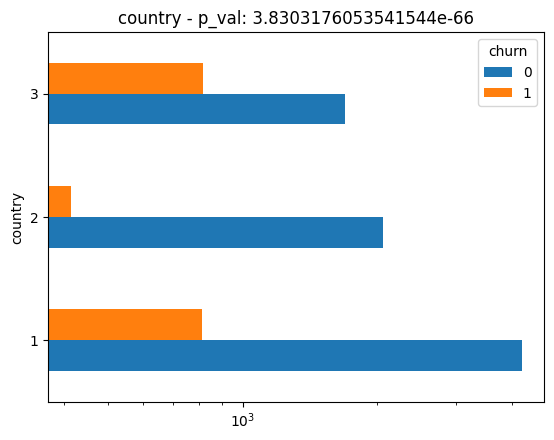

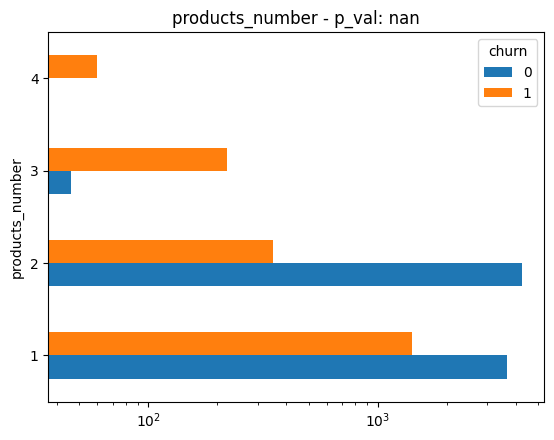

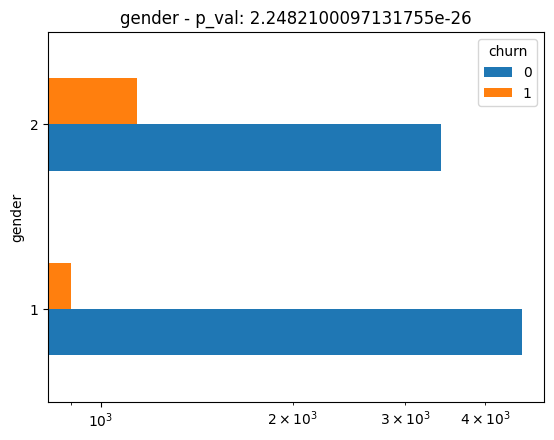

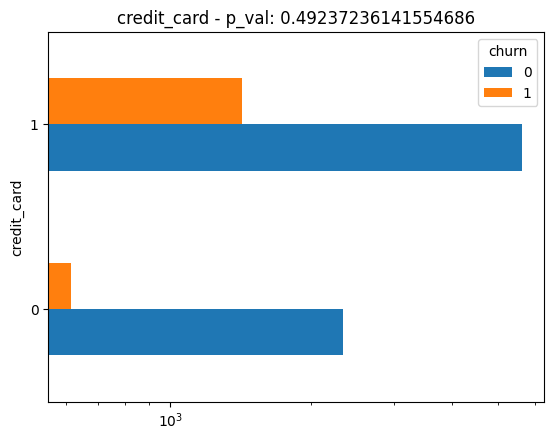

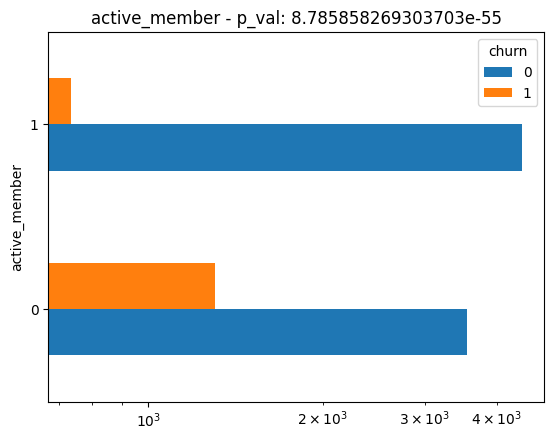

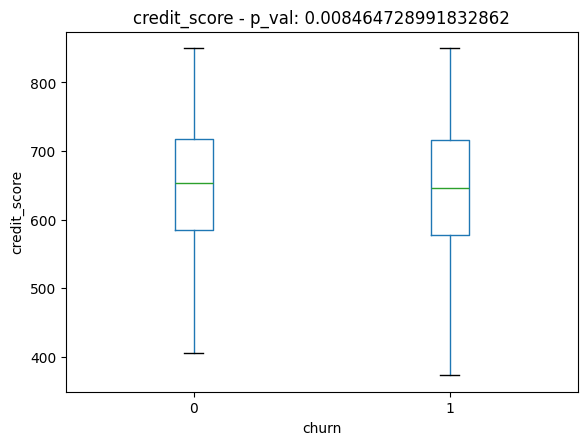

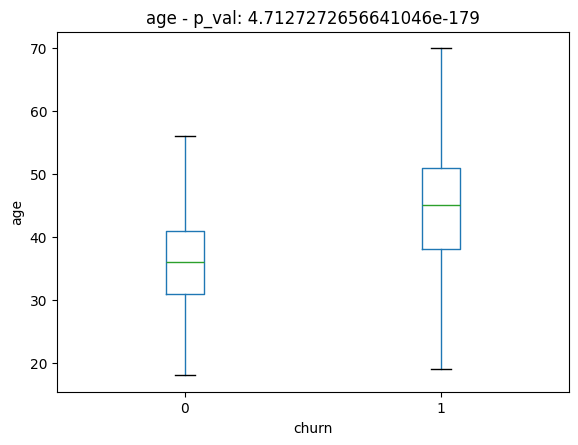

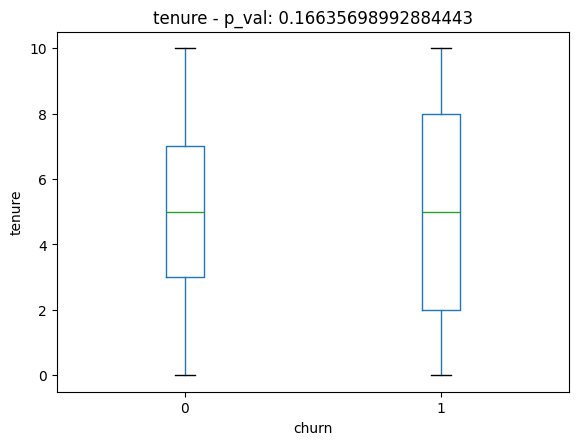

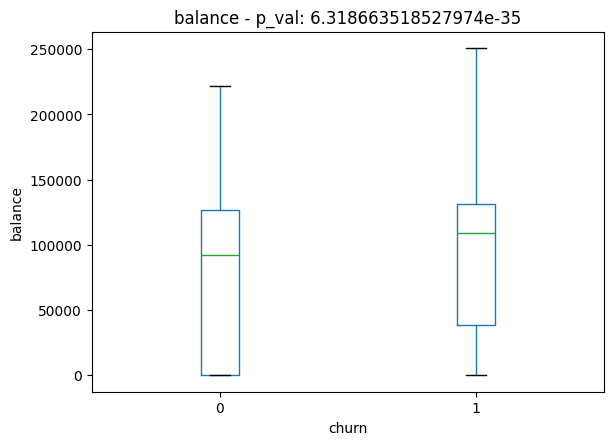

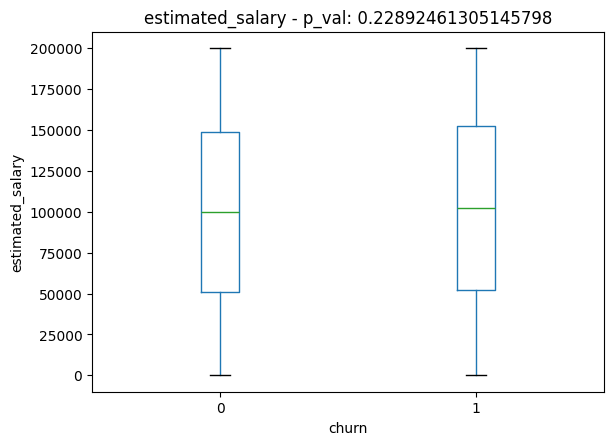

In [26]:
predictors_evaluation = dict()
for col in config.CAT_VARS:
    predictors_evaluation[col] = target_vs_categorical(df, x=col, y='churn')

for col in config.NUM_VARS:
    predictors_evaluation[col] = target_vs_numerical(df, x=col, y='churn')

<Axes: >

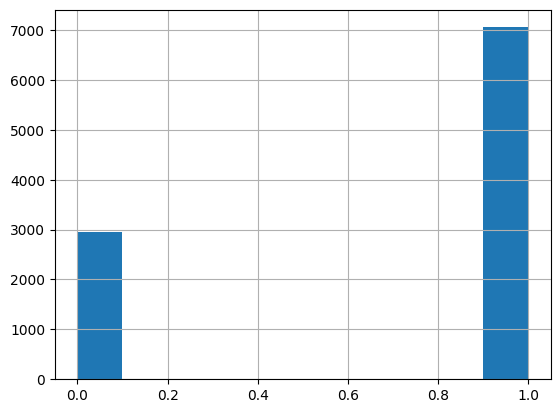

In [27]:
df['credit_card'].hist()

In [28]:
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [29]:
#### data transformation ####
cat_vars = list(map(str.lower, config.CAT_VARS))
num_vars = list(map(str.lower, config.NUM_VARS))
RANDOM_STATE = 101

def rescale_data(df:pd.DataFrame, method:str='standardize', mode:str='training', columns:list=[], job_id:str="") -> pd.DataFrame:
    """
    Rescale data.
    :param df: DataFrame
    :param method: str, 'standardize' or 'minmax'
    :param mode: str, 'training' or 'inference'
    :return: DataFrame
    """
    assert method in ('standardize', 'minmax'), f"{method} is not a valid method (standardize, minmax)"
    assert mode in ('training', 'inference'), f"{mode} is not a valid mode (training, inference)"
    for col in columns:
        assert col in df.columns

    if mode=='training':
        if method=='standardize':
            scaler = StandardScaler()
            scaler.fit(df[columns])
        if method=='minmax':
            scaler = MinMaxScaler()
            scaler.fit(df[columns])
        model = {
            'scaler': scaler,
            'method': method,
        }

        helpers.save_model_as_pickle(model, f"{config.PATH_DIR_MODELS}/{job_id}_numerical_scaler.pkl")
        df[list(map(lambda x: f"{method}_{x}", columns))] = scaler.transform(df[columns])
        return df
    if mode=='inference':
        model = helpers.load_model_from_pickle(model_name=f"{job_id}_numerical_scaler.pkl")
        scaler = model['scaler']
        method = model['method']
        for col in columns:
            try:
                df[col].astype(float)
            except:
                print("[DEBUG] Column skipped:", col)
        df[list(map(lambda x: f"{method}_{x}", columns))] = scaler.transform(df[columns])
        return df
    

###### Preprocess ######
def split_train_test(df:pd.DataFrame, test_size:float, method:str='random'):
    """
    Split data into train and test.
    :param df: DataFrame
    :param test_size: float, between 0 and 0.99
    :param method: str, 'time based' or 'random'
    :return: (DataFrame, DataFrame)
    """
    if method=='random':
        return df.sample(frac=1, random_state=config.RANDOM_STATE).iloc[:int(len(df)*test_size)], df.sample(frac=1, random_state=config.RANDOM_STATE).iloc[int(len(df)*test_size):]
    if method=='time based':
        unique_dates = sorted(df["application_date"].unique())
        
        train_dates = unique_dates[:int(len(unique_dates)*(1-test_size))]
        test_dates = unique_dates[unique_dates.index(train_dates[-1])+1:]
        train_df = df[df["application_date"].isin(train_dates)]
        test_df = df[df["application_date"].isin(test_dates)]

        return train_df, test_df
    raise(ValueError(f"{method} is not a valid method (time based, random)"))


def preprocess_data(df:pd.DataFrame, mode:str, job_id:str=None, rescale=False, ref_job_id:str=None) -> pd.DataFrame:
    """
    Pre-process data and save preprocessed datasets for later use.
    :param df: DataFrame
    :param mode: str, 'training' or 'inference'
    :param job_id: str, job_id for the preprocessed dataset
    :param rescale: bool, whether to rescale data.
    :param ref_job_id: str, job_id of the last deployed model. Usefull when doing inference.
    :return: DataFrame
    """
    assert mode in ('training', 'inference')
    
    if mode=='training':
        assert config.TARGET in df.columns, f"{config.TARGET} not in {df.columns}"

    df.columns = list(map(str.lower, df.columns))
    initial_size = df.shape[0]
    df = df[df["customer_id"].notnull() & df["churn"].notnull()]
    #if mode=='training':
    #    df["loan_status"] = df["loan_status"].str.lower()
    if df.shape[0] != initial_size:
        print(f"[WARNING] Dropped {initial_size - df.shape[0]} rows with null values in (customer_id, churn)")
    df = enforce_datatypes_on_variables(df, cat_vars=config.CAT_VARS, num_vars=config.NUM_VARS)
    #df = engineer_variables(df)
    if mode=='training':
        # split train and test data before encoding categorical variables and imputing missing values
        train_df, test_df = split_train_test(df, config.TEST_SPLIT_SIZE, method=config.SPLIT_METHOD)
        train_df = encode_categorical_variables(train_df, mode="training", job_id=job_id)
        train_df = impute_missing_values(train_df, method="basic", mode="training", job_id=job_id)
        if rescale:
            train_df = rescale_data(train_df, method=config.RESCALE_METHOD, mode="training", columns=num_vars)# + engineered_vars["numerical"])
        helpers.save_dataset(train_df, os.path.join(config.PATH_DIR_DATA, "preprocessed", f"{job_id}_training.csv"))
        preprocess_data(test_df, mode="inference", job_id=job_id, ref_job_id=job_id)
    else:
        # if mode is infer, no need to split train and test data
        test_df = encode_categorical_variables(df, mode="inference", job_id=ref_job_id)
        test_df = impute_missing_values(test_df, method="basic", mode="inference", job_id=ref_job_id)
        if rescale:
            test_df = rescale_data(test_df, method=config.RESCALE_METHOD, mode="inference", columns=num_vars)# + engineered_vars["numerical"])
        helpers.save_dataset(test_df, os.path.join(config.PATH_DIR_DATA, "preprocessed", f"{job_id}_inference.csv"))
    return test_df


In [31]:
#change this filename and job id accordingly
filename = "../dags/data/raw/0167d439ab2245668cca4479101f90cd_2015-01-01_2015-05-31.csv"
job_id = "0167d439ab2245668cca4479101f90cd"
df = he.load_dataset(os.path.join(filename))
_ = preprocess_data(df=df, mode="training", job_id=job_id, rescale=False, ref_job_id=None)

[INFO] Treating missing values in column: customer_id
[INFO] Treating missing values in column: credit_score
[INFO] Treating missing values in column: country
[INFO] Treating missing values in column: gender
[INFO] Treating missing values in column: age
[INFO] Treating missing values in column: tenure
[INFO] Treating missing values in column: balance
[INFO] Treating missing values in column: products_number
[INFO] Treating missing values in column: credit_card
[INFO] Treating missing values in column: active_member
[INFO] Treating missing values in column: estimated_salary
[INFO] Treating missing values in column: churn
[INFO] Model saved as pickle file: ../dags/models/0167d439ab2245668cca4479101f90cd_missing_values_model.pkl
[INFO] Dataset saved to ../dags/data/preprocessed/0167d439ab2245668cca4479101f90cd_training.csv
[INFO] Dataset saved to ../dags/data/preprocessed/0167d439ab2245668cca4479101f90cd_inference.csv


In [33]:
tdf = pd.read_csv("../dags/data/preprocessed/0167d439ab2245668cca4479101f90cd_training.csv")
vdf = pd.read_csv("../dags/data/preprocessed/0167d439ab2245668cca4479101f90cd_inference.csv")

<Axes: >

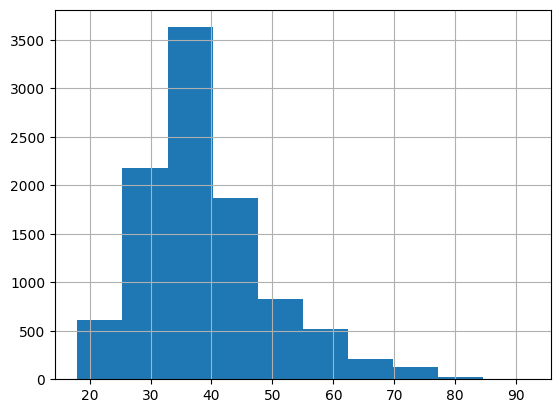

In [34]:
df['age'].hist()

<Axes: >

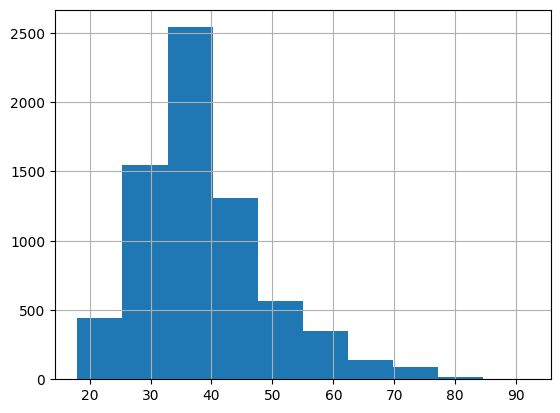

In [35]:
vdf['age'].hist()

In [36]:
tdf[config.PREDICTORS + [config.TARGET]].head().T

,0,1,2,3,4
country,2.00,1.00,1.00,1.00,3.00
products_number,2.00,1.00,1.00,2.00,1.00
gender,1.00,1.00,2.00,1.00,2.00
credit_card,1.00,1.00,0.00,0.00,1.00
active_member,1.00,1.00,1.00,1.00,0.00
credit_score,619.00,616.00,516.00,494.00,655.00
age,52.00,23.00,46.00,28.00,46.00
tenure,8.00,8.00,6.00,9.00,7.00
balance,0.00,73112.95,62212.29,114731.76,137145.12
estimated_salary,123242.11,62733.05,171681.86,79479.74,115146.40


**Next steps:**
- load training and test datasets
- check sanity
- train multiple models: randomForest, gradientBoosting
- select the best model
    - auc >= 0.7
    - abs(auc_train - auc_test) <=0.1
- deploy model: compare the best model to last deployed model

In [37]:
import datetime
import sys
import os
import json
import re
import pickle
import traceback
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score,  accuracy_score, f1_score, precision_score, recall_score, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pprint import pprint
from importlib import reload

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'dags', 'src'))

import helpers
import config

reload(helpers)
reload(config)

[INFO] Connection to `localhost:postgres` initiated!


<module 'config' from '/Users/ejenamvictor/Desktop/code/docker-airflow-run/dags/src/config.py'>

In [38]:
#### helpers.py methods ####
def load_dataset(path:str) -> pd.DataFrame:
    """
    Load data set.
    :param path: str
    :return: DataFrame
    """
    return pd.read_csv(path)

def check_dataset_sanity(df:pd.DataFrame) -> bool:
    nulls = df.isnull().sum()
    nulls = nulls[nulls>0].index.tolist()
    if len(nulls)==0:
        return True
    else:
        raise(Exception(f"There are null values in the training dataset: {nulls}"))

def save_model_as_pickle(model, model_name, directory=None):
    """
    Save a model as a pickle file.
    :param model: AnyType
    :param model_name: str
    :param directory: str
    :return: None
    """
    if directory:
        filename = os.path.join(directory, model_name+".pkl")
    else:
        filename = os.path.join(config.PATH_DIR_MODELS, model_name+".pkl")
    with open(filename, "wb") as f:
        pickle.dump(model, f)
    print("[INFO] Model saved as pickle file:", filename)

def save_model_as_json(model:dict, model_name:str, directory:str=None):
    """
    Save a model as a json file.
    :param model: dict
    :param model_name: str
    :param directory: str
    :return: None
    """
    if directory:
        filename = os.path.join(directory, model_name+".json")
    else:
        filename = os.path.join(config.PATH_DIR_MODELS, model_name+".json")
    with open(filename, "w") as f:
        json.dump(model, f)
    print("[INFO] Model saved as json file:", filename)

def persist_deploy_report(job_id:str, model_name:str):
    """
    Persist the deploy report of a job.
    :param job_id: str
    :return: None
    """
    report = {
        "job_id": job_id,
        "missing_values": f"{job_id}_missing_values_model.pkl",
        "prediction_model": f"{model_name}.pkl",
        "train_report": f"{job_id}_train_report.json",
    }
    json.dump(report, open(os.path.join(config.PATH_DIR_MODELS, f"deploy_report.json"), "w"))
    print(f'[INFO] Deployment report saved as {os.path.join(config.PATH_DIR_MODELS, f"deploy_report.json")}')

In [39]:
##### train.py methods #####
def train(train_dataset_filename:str=None, test_dataset_filename:str=None, job_id="", rescale=False):
    """
    Train a model on the train dataset loaded from `train_dataset_filename` and test dataset loaded from `test_dataset_filename`
    :param train_dataset_filename: str
    :param test_dataset_filename: str
    :param job_id: str
    :param rescale: bool, if true, scaled numerical variables used
    :return: None
    """
    if train_dataset_filename==None:
        train_dataset_filename = os.path.join(config.PATH_DIR_DATA, "preprocessed", f"{job_id}_training.csv")
    if test_dataset_filename==None:
        test_dataset_filename = os.path.join(config.PATH_DIR_DATA, "preprocessed", f"{job_id}_inference.csv")
    tdf = helpers.load_dataset(train_dataset_filename)
    vdf = helpers.load_dataset(test_dataset_filename)
    helpers.check_dataset_sanity(tdf)
    helpers.check_dataset_sanity(vdf)
    
    predictors = config.PREDICTORS
    target = config.TARGET
    if rescale:
        for col in predictors:
            if f"{config.RESCALE_METHOD}_{col}" in tdf.columns:
                tdf[col] = tdf[f"{config.RESCALE_METHOD}_{col}"]
            if f"{config.RESCALE_METHOD}_{col}" in vdf.columns:
                vdf[col] = vdf[f"{config.RESCALE_METHOD}_{col}"]
        
    rf = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=config.RANDOM_SEED)
    gb = GradientBoostingClassifier(n_estimators=10, max_depth=10, random_state=config.RANDOM_SEED)
    X, Y = tdf[predictors], tdf[target]
    report = dict()
    models = dict()
    for cl, name in [(rf, "rf"), (gb, "gb")]:
        print("[INFO] Training model:", name)
        cl.fit(X, Y)
        t_pred = cl.predict(X)
        v_pred = cl.predict(vdf[predictors])
        t_prob = cl.predict_proba(X)[:, 1]
        v_prob = cl.predict_proba(vdf[predictors])[:, 1]
        report[f"{name}_train"] = performance_report(Y, t_pred, t_prob)
        report[f"{name}_test"] = performance_report(vdf[target], v_pred, v_prob)
        models[name] = cl
        
    model_name = select_model(pd.DataFrame(report), metric=config.MODEL_PERFORMANCE_METRIC, model_names=list(models.keys()))
    report["final_model"] = model_name
    helpers.save_model_as_pickle(models[model_name], f"{job_id}_{model_name}")
    helpers.save_model_as_json(report, f"{job_id}_train_report")
    return report

def performance_report(y_true, y_pred, y_prob):
    """
    Generate performance report for a model.
    :param y_true: np.array, true value
    :param y_pred: np.array, predicted values
    :param y_prob: np.array, prediction probability
    :return: dict
    """
    report = dict()
    report["dataset size"] = y_true.shape[0]
    report["positive rate"] = y_true.sum()/y_true.shape[0]
    report["accuracy"] = accuracy_score(y_true, y_pred)
    report["f1"] = f1_score(y_true, y_pred)
    report["precision"] = precision_score(y_true, y_pred)
    report["recall"] = recall_score(y_true, y_pred)
    report["auc"] = roc_auc_score(y_true, y_prob)
    return report

def select_model(df:pd.DataFrame, metric:str=config.MODEL_PERFORMANCE_METRIC, model_names:list=["rf", "gb"], performance_thresh:float=config.MODEL_PERFORMANCE_THRESHOLD, degradation_thresh:float=config.MODEL_DEGRADATION_THRESHOLD)->str:
    """
    Select the best model based on their performance reports.
        - metric >= performance_thresh where metric can be auc, recall, precision, f1_score, ... and performance_thresh is any value between 0.0 and 1.0
        - abs(<metric>_train - <metric>_test) <= degradation_thresh
    :param df: pd.DataFrame, performance report
    :param metric: str, metric to select the best model.
    :param model_names: list, model names to select from.
    :param performance_thresh: float, threshold for the performance.
    :return: str, model name.
    """
    degradation_performance = []
    for model in model_names:
        if df.loc[metric, f"{model}_train"] < performance_thresh:
            continue
        degradation = df.loc[metric, f"{model}_train"] - df.loc[metric, f"{model}_test"]
        if degradation < degradation_thresh:
            degradation_performance.append((model, degradation))
    if len(degradation_performance) == 0.0:
        raise(Exception("No model selected: all models have performance below the threshold. Possible overfitting."))
    return min(degradation_performance, key=lambda x: x[1])[0]

def pick_model_and_deploy(job_id, models, df, metric="auc", predictors=config.PREDICTORS, target=config.TARGET)->str:
    """
    Among all `models`, select the model that performs best on df and mark it for deployment.
    :param job_id: str, job id.
    :param models: list of key-value items {"job_id": <str>, "purpose_to_int: <str>, "missing_values": <str>, "prediction_model": <>, "train_report": <str>}
    :param df: pd.DataFrame, test dataset
    :param metric: str, metric used to select the best model.
    :param predictors: list, predictors to use.
    :param target: str, target to use.
    :return: str
    """
    assert len(models) > 0, "`models` cannot be empty"
    if len(models)==1:
        model_name = models[0]["model_name"]
        helpers.persist_deploy_report(job_id, model_name)
        return model_name
    cols = set(predictors).difference(set(df.columns))
    assert cols == set(), f"{cols} not in {df.columns}"
    score = 0
    m_idx = 0
    for i, m in enumerate(models):
        y_true = df[target]
        y_pred = m["model"].predict(df[predictors])
        y_prob = m["model"].predict_proba(df[predictors])[:, 1]
        r = performance_report(y_true, y_pred, y_prob)
        if r[metric] > score:
            score = r[metric]
            m_idx = i
    helpers.persist_deploy_report(job_id, models[m_idx]["model_name"])
    return models[m_idx]["model_name"]

In [41]:
job_id = "0167d439ab2245668cca4479101f90cd"
report = train(job_id="0167d439ab2245668cca4479101f90cd")
pprint(report)

[INFO] Training model: rf
[INFO] Training model: gb
[INFO] Model saved as pickle file: ../dags/models/0167d439ab2245668cca4479101f90cd_rf.pkl
[INFO] Model saved as json file: ../dags/models/0167d439ab2245668cca4479101f90cd_train_report.json
{'final_model': 'rf',
 'gb_test': {'accuracy': 0.8442857142857143,
             'auc': 0.7892590261015909,
             'dataset size': 7000,
             'f1': 0.4995408631772268,
             'positive rate': 0.20214285714285715,
             'precision': 0.7129750982961992,
             'recall': 0.384452296819788},
 'gb_train': {'accuracy': 0.9566666666666667,
              'auc': 0.997356867209874,
              'dataset size': 3000,
              'f1': 0.8835125448028673,
              'positive rate': 0.20733333333333334,
              'precision': 0.9979757085020243,
              'recall': 0.792604501607717},
 'rf_test': {'accuracy': 0.8535714285714285,
             'auc': 0.8261434749186205,
             'dataset size': 7000,
             

In [43]:
model = pick_model_and_deploy(
    job_id=job_id,
    df = pd.read_csv("../dags/data/preprocessed/0167d439ab2245668cca4479101f90cd_inference.csv"),
    models = [{
        "model_name": f"{job_id}_{report['final_model']}", 
        "model": pickle.load(open("../dags/models/0167d439ab2245668cca4479101f90cd_rf.pkl", "rb"))
    }]
)
print("Deployed model:", model)

[INFO] Deployment report saved as ../dags/models/deploy_report.json
Deployed model: 0167d439ab2245668cca4479101f90cd_rf


In [44]:
print("Deloyment Report Sample")
pprint(json.load(open("../dags/models/deploy_report.json", "r")))

Deloyment Report Sample
{'job_id': '0167d439ab2245668cca4479101f90cd',
 'missing_values': '0167d439ab2245668cca4479101f90cd_missing_values_model.pkl',
 'prediction_model': '0167d439ab2245668cca4479101f90cd_rf.pkl',
 'purpose_to_int': '0167d439ab2245668cca4479101f90cd_purpose_to_int_model.json',
 'train_report': '0167d439ab2245668cca4479101f90cd_train_report.json'}


# Monitoring ML Training Pipeline: Drifts

**Quick recap:**
- Goal: 
    - Building a classication model for customer churn that predicts whether a customer will churn 
     - Introduce autonomous monitoring checkpoints orchestrated with Airflow DAGS
- Download raw data: `/raw/0e8eabdf468949f2806827e1d3f35537_2015-01-01_2015-05-31.csv`
- Preprocessed the data into:
    - training dataset: `preprocessed/12196ecaa65e4831987aee4bfced5f60.csv`
    - test dataset: `preprocessed/12196ecaa65e4831987aee4bfced5f60.csv`

- Trained and deployed the model
    - JobID: 12196ecaa65e4831987aee4bfced5f60
    - Missing values: 12196ecaa65e4831987aee4bfced5f60_missing_values_model.pkl
    - Purpose to Integer: 12196ecaa65e4831987aee4bfced5f60_purpose_to_int_model.json
    - Prediction model: 12196ecaa65e4831987aee4bfced5f60_rf.pkl

**Next steps:**
- data quality check
- data drift check
- model drift check
- comparative model evaluation

<div>
<img src="../images/monitored_pipeline.png" width="850"/>
</div>

**Tools**
- deepchecks

## Motivation
In real life, data science teams will spend more of their time on developing new models and little to no time to daily check on their models currently in production. Hence, there is need of an automated monitoring system that can alert the team whenever there is any significant change that is impacting prediction performance on their models

### What to monitor in production?

**Data quality issues**

Depending on the process the data goes through until being fed to a model. Data could be coming multiple sources with different formats or formats changing over time, renamed fields, new categories, etc. Any of these changes can lead to a significant impact on the model performance

**Data drift & Concept drift**

In real world, data is always changing. Changes can be due to change in business behavior such as a company operating in a new region, the company introducing a new product, new competitions in the market, social trends, global events affecting each industry ... These changes may affect the distribution of the data as we knew it at the time of the previous training session and hence the data we trained our model on becomes less and less relevant to the business problem over time.

*Data drift* happens when the input feature probability distribution P(X) changes over time. This can be due to either some change in the data structure or change in real world.

*Concept drifts* happens when the probability distribution P(Y|X) of the output changes over time. This can be caused by changes in data structure or a shift in real world data, which affects prediction quality indefinitely. A typical example is Digital Marketing where the common metric CTR can change drastically due to new competitions. Concept drift can be *gradual*, *sudden*, *in blips* or *recurring*.

**Model drift**

The model drift happens when the predictive power of last trained model on any new dataset deteriotes over time. This is usually a consequence of data and concept drifts. In other situation, it could also be due to a model that wasn't stabilized against bias or overfitting. In our current situation, we will assume that the model was stabilized enough during training.

**Statistical metrics**
- [Kolomogorov-Smirnoff (K-S) test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)
- [Cramer's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V)
- [Predictive Power Score](https://docs.deepchecks.com/en/stable/checks_gallery/tabular/train_test_validation/plot_feature_label_correlation_change.html#)
- Outlier detection

**Resources**
- [How to monitor ml models in production](https://deepchecks.com/how-to-monitor-ml-models-in-production/)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import traceback
import pandas as pd
import numpy as np
import os
import json
import pickle
import datetime
from sklearn.ensemble import BaseEnsemble

from deepchecks.tabular import Dataset
from deepchecks.tabular import Suite
from deepchecks.tabular.checks import WholeDatasetDrift, DataDuplicates, NewLabelTrainTest, TrainTestFeatureDrift, TrainTestLabelDrift
from deepchecks.tabular.checks import FeatureLabelCorrelation, FeatureLabelCorrelationChange, ConflictingLabels, OutlierSampleDetection 
from deepchecks.tabular.checks import WeakSegmentsPerformance, RocReport, ConfusionMatrixReport, TrainTestPredictionDrift, CalibrationScore, BoostingOverfit

import sys
from importlib import reload
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'dags', 'src'))

import helpers
import config
import preprocess

reload(helpers)
reload(config)
reload(preprocess)

In [ ]:
#### drifts.py methods ####
def check_data_quality(df:pd.DataFrame, predictors:list, target:str, job_id:str):
    """
    checks for data quality.
    A report will be saved in the results directory.
    :param df: dataframe to check
    :param predictors: predictors to check for drifts
    :param target: target variable to check for drifts
    :param job_id: job ID
    :return: boolean
    """
    features = [col for col in predictors if col in df.columns]
    cat_features = [col for col in config.CAT_VARS if col in df.columns]
    dataset = Dataset(df, label=target, features=features, cat_features=cat_features, datetime_name=config.DATETIME_VARS[0])
    retrain_suite = Suite("data quality",
        DataDuplicates().add_condition_ratio_less_or_equal(0.3), #Checks for duplicate samples in the dataset
        ConflictingLabels().add_condition_ratio_of_conflicting_labels_less_or_equal(0), #Find samples which have the exact same features' values but different labels
        FeatureLabelCorrelation().add_condition_feature_pps_less_than(0.9), #Return the PPS (Predictive Power Score) of all features in relation to the label
        OutlierSampleDetection(outlier_score_threshold=0.7).add_condition_outlier_ratio_less_or_equal(0.1), #Detects outliers in a dataset using the LoOP algorithm
    )
    r = retrain_suite.run(dataset)
    try:
        r.save_as_html(f"{config.PATH_DIR_RESULTS}/{job_id}_data_quality_report.html")
        print("[INFO] Data quality report saved as {}".format(f"{config.PATH_DIR_RESULTS}/{job_id}_data_quality_report.html"))
    except Exception as e:
        print(f"[WARNING][DRIFTS.SKIP_TRAIN] {traceback.format_exc()}")
    return {"report": r, "retrain": r.passed()}

def check_data_drift(ref_df:pd.DataFrame, cur_df:pd.DataFrame, predictors:list, target:str, job_id:str):
    """
    Check for data drifts between two datasets and decide whether to retrain the model. 
    A report will be saved in the results directory.
    :param ref_df: Reference dataset
    :param cur_df: Current dataset
    :param predictors: Predictors to check for drifts
    :param target: Target variable to check for drifts
    :param job_id: Job ID
    :return: boolean
    """
    ref_features = [col for col in predictors if col in ref_df.columns]
    cur_features = [col for col in predictors if col in cur_df.columns]
    ref_cat_features = [col for col in config.CAT_VARS if col in ref_df.columns]
    cur_cat_features = [col for col in config.CAT_VARS if col in cur_df.columns]
    ref_dataset = Dataset(ref_df, label=target, features=ref_features, cat_features=ref_cat_features, datetime_name=config.DATETIME_VARS[0])
    cur_dataset = Dataset(cur_df, label=target, features=cur_features, cat_features=cur_cat_features, datetime_name=config.DATETIME_VARS[0])
    
    suite = Suite("data drift",
        NewLabelTrainTest(),
        WholeDatasetDrift().add_condition_overall_drift_value_less_than(0.01), #0.2
        FeatureLabelCorrelationChange().add_condition_feature_pps_difference_less_than(0.05), #0.2
        TrainTestFeatureDrift().add_condition_drift_score_less_than(0.01), #0.1
        TrainTestLabelDrift().add_condition_drift_score_less_than(0.01) #0.1
    )
    r = suite.run(ref_dataset, cur_dataset)
    retrain = (len(r.get_not_ran_checks())>0) or (len(r.get_not_passed_checks())>0)
    
    try:
        r.save_as_html(f"{config.PATH_DIR_RESULTS}/{job_id}_data_drift_report.html")
        print("[INFO] Data drift report saved as {}".format(f"{config.PATH_DIR_RESULTS}/{job_id}_data_drift_report.html"))
    except Exception as e:
        print(f"[WARNING][DRIFTS.check_DATA_DRIFT] {traceback.format_exc()}")
    return {"report": r, "retrain": retrain}

def check_model_drift(ref_df:pd.DataFrame, cur_df:pd.DataFrame, model:BaseEnsemble, predictors:list, target:str, job_id:str):
    """
    Using the same pre-trained model, compare drifts in predictions between two datasets and decides whether to retrain the model. A report will be saved in the results directory.
    :param ref_df: Reference dataset
    :param cur_df: Current dataset
    :param model: Pre-trained model. Only scikit-learn and xgboost models are supported.
    :param predictors: Predictors to check for drifts
    :param target: Target variable to check for drifts
    :param job_id: Job ID
    :return: boolean
    """
    ref_features = [col for col in predictors if col in ref_df.columns]
    cur_features = [col for col in predictors if col in cur_df.columns]
    ref_cat_features = [col for col in config.CAT_VARS if col in ref_df.columns]
    cur_cat_features = [col for col in config.CAT_VARS if col in cur_df.columns]
    ref_dataset = Dataset(ref_df, label=target, features=ref_features, cat_features=ref_cat_features, datetime_name=config.DATETIME_VARS[0])
    cur_dataset = Dataset(cur_df, label=target, features=cur_features, cat_features=cur_cat_features, datetime_name=config.DATETIME_VARS[0])
    
    suite = Suite("model drift",
        #For each class plots the ROC curve, calculate AUC score and displays the optimal threshold cutoff point.
        RocReport().add_condition_auc_greater_than(0.7), 
        #Calculate prediction drift between train dataset and test dataset, Cramer's V for categorical output and Earth Movers Distance for numerical output.
        TrainTestPredictionDrift().add_condition_drift_score_less_than(max_allowed_categorical_score=0.1) 
        )
    r = suite.run(ref_dataset, cur_dataset, model)
    retrain = (len(r.get_not_ran_checks())>0) or (len(r.get_not_passed_checks())>0)
    try:
        r.save_as_html(f"{config.PATH_DIR_RESULTS}/{job_id}_model_drift_report.html")
        print("[INFO] Model drift report saved as {}".format(f"{config.PATH_DIR_RESULTS}/{job_id}_model_drift_report.html"))
    except Exception as e:
        print(f"[WARNING][DRIFTS.check_MODEL_DRIFT] {traceback.format_exc()}")
    
    return {"report": r, "retrain": retrain}

In [ ]:
job_id1 = "a2b34a5fa9d7443d9cadc7c4adf58065"
job_id2 = "a6f0952cd9b54e319ac4fbcef223556c" 
job_id3 = "aa4c3eaadb02409281b589829e3c9370"
filename1 = f"../dags/data/raw/{job_id1}_2015-01-01_2015-05-31.csv"
filename2 = f"../dags/data/raw/{job_id2}_2015-01-01_2015-05-31.csv"
filename3 = f"../dags/data/raw/{job_id3}_2015-06-01_2015-12-31.csv"

df1 = pd.read_csv(filename1)
df2 = pd.read_csv(filename2)
df3 = pd.read_csv(filename3)

tdf1 = pd.read_csv(f"../dags/data/preprocessed/{job_id1}_training.csv")
vdf1 = pd.read_csv(f"../dags/data/preprocessed/{job_id1}_inference.csv")
vdf2 = preprocess.preprocess_data(df=df2, mode="inference", job_id=job_id2, rescale=False, ref_job_id=job_id1)
vdf3 = preprocess.preprocess_data(df=df3, mode="inference", job_id=job_id3, rescale=False, ref_job_id=job_id1)

deploy_report = json.load(open(f"../dags/models/deploy_report.json", "r"))
pred_model = pickle.load(open(f"../dags/models/{deploy_report['prediction_model']}", "rb"))

In [ ]:
dq_chk1 = check_data_quality(df1, predictors=config.PREDICTORS, target=config.TARGET, job_id=job_id1)
dq_chk2 = check_data_quality(df2, predictors=config.PREDICTORS, target=config.TARGET, job_id=job_id2)
dq_chk3 = check_data_quality(df3, predictors=config.PREDICTORS, target=config.TARGET, job_id=job_id3)

In [ ]:
print(f"retrain: {dq_chk1['retrain']}")
dq_chk1['report']

In [ ]:
# compare raw data
dd_1_2 = check_data_drift(ref_df=df1, cur_df=df2, predictors=config.PREDICTORS, target=config.TARGET, job_id=job_id2)
dd_1_3 = check_data_drift(ref_df=df1, cur_df=df3, predictors=config.PREDICTORS, target=config.TARGET, job_id=job_id3)

# compare preprocessed datasets
dd_1_2b = check_data_drift(ref_df=vdf1, cur_df=vdf2, predictors=config.PREDICTORS, target=config.TARGET, job_id=job_id2+"_b")
dd_1_3b = check_data_drift(ref_df=vdf1, cur_df=vdf3, predictors=config.PREDICTORS, target=config.TARGET, job_id=job_id3+"_b")

In [ ]:
print(f"retrain: {dd_1_2b['retrain']}")
dd_1_2b['report']

In [ ]:
print(f"retrain: {dd_1_3b['retrain']}")
dd_1_3b['report']

In [ ]:
md_1_2 = check_model_drift(ref_df=vdf1, cur_df=vdf2, model=pred_model, predictors=config.PREDICTORS, target=config.TARGET, job_id=job_id2)
md_1_3 = check_model_drift(ref_df=vdf1, cur_df=vdf3, model=pred_model, predictors=config.PREDICTORS, target=config.TARGET, job_id=job_id3)

In [ ]:
print(f"retrain: {md_1_3['retrain']}")
md_1_3['report']